In [218]:
import chess
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd

PIECE_TO_INDEX = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5,
}

def _get_rook_edges(square: int) -> List[int]:
    edges = []
    file, rank = chess.square_file(square), chess.square_rank(square)
    for i in range(8):
        if i != file:
            edges.append(chess.square(i, rank))
        if i != rank:
            edges.append(chess.square(file, i))
    return edges

def _get_bishop_edges(square: int) -> List[int]:
    edges = []
    file, rank = chess.square_file(square), chess.square_rank(square)
    for i in range(1, 8):
        # 右上, 左下, 左上, 右下
        if chess.square_file(square) + i < 8 and chess.square_rank(square) + i < 8:
            edges.append(square + i * 9)
        if chess.square_file(square) - i >= 0 and chess.square_rank(square) - i >= 0:
            edges.append(square - i * 9)
        if chess.square_file(square) - i >= 0 and chess.square_rank(square) + i < 8:
            edges.append(square + i * 7)
        if chess.square_file(square) + i < 8 and chess.square_rank(square) - i >= 0:
            edges.append(square - i * 7)
    return edges

def _get_knight_moves(square: int) -> List[int]:
    edges = []
    file, rank = chess.square_file(square), chess.square_rank(square)
    # 所有8个马步方向
    offsets = [(1, 2), (1, -2), (-1, 2), (-1, -2),
               (2, 1), (2, -1), (-2, 1), (-2, -1)]
    for f_off, r_off in offsets:
        new_file, new_rank = file + f_off, rank + r_off
        if 0 <= new_file < 8 and 0 <= new_rank < 8:
            edges.append(chess.square(new_file, new_rank))
    return edges

def _create_static_edge_index() -> np.ndarray:
    edges = []
    for square in range(64):
        # 1. Queen's moves (Rook + Bishop)
        queen_moves = _get_rook_edges(square) + _get_bishop_edges(square)
        for move in set(queen_moves):
            edges.append((square, move))

        # 2. Knight's moves
        for move in _get_knight_moves(square):
            edges.append((square, move))
            
        # 3. Add self-loops for every node
        edges.append((square, square))

    # 转换为COO格式 (Coordinate list)
    edge_index = np.array(list(set(edges))).T
    return edge_index

# --- 主编码函数 ---

def encode_board_to_gnn_input(board: chess.Board) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    node_features = np.zeros((64, 12), dtype=np.float32)

    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            node_features[i, PIECE_TO_INDEX[piece.piece_type]] = 1
            node_features[i, 6 + piece.color] = 1

        if (chess.square_file(i) + chess.square_rank(i)) % 2 != 0:
            node_features[i, 8] = 1

        node_features[i, 9] = chess.square_file(i) / 7.0
        node_features[i, 10] = chess.square_rank(i) / 7.0

        if board.ep_square is not None and i == board.ep_square:
            node_features[i, 11] = 1

    edge_index = _create_static_edge_index()
    global_features = np.zeros(8, dtype=np.float32)

    global_features[0 if board.turn == chess.WHITE else 1] = 1
    if board.has_kingside_castling_rights(chess.WHITE): global_features[2] = 1
    if board.has_queenside_castling_rights(chess.WHITE): global_features[3] = 1
    if board.has_kingside_castling_rights(chess.BLACK): global_features[4] = 1
    if board.has_queenside_castling_rights(chess.BLACK): global_features[5] = 1
    global_features[6] = min(board.halfmove_clock, 100) / 100.0
    if board.is_repetition():
        global_features[7] = 1

    return node_features, edge_index, global_features

if __name__ == '__main__':
    board = chess.Board("rnbqkbnr/ppp1p1pp/8/3pPp2/8/8/PPPP1PPP/RNBQKBNR w KQkq f6 0 3")
    print("当前棋盘 (FEN):")
    print(board.fen())
    print("\n棋盘可视化:")
    print(board)

    nodes, edges, g_features = encode_board_to_gnn_input(board)

    print("\n--- Zięba's ChessGNN 编码结果 ---")
    print(f"节点特征矩阵 (Node Features) shape: {nodes.shape}")
    print(f"边索引 (Edge Index) shape: {edges.shape}")
    print(f"全局特征向量 (Global Features) shape: {g_features.shape}")

    print("\n全局特征向量详解:")
    print(f"[White Turn, Black Turn]: [{g_features[0]}, {g_features[1]}]")
    print(f"[WK, WQ, BK, BQ]: [{g_features[2]}, {g_features[3]}, {g_features[4]}, {g_features[5]}]")
    print(f"Normalized Half-move Clock: {g_features[6]:.2f}")
    print(f"Is Repetition: {g_features[7]}")
    
    print(f"\n静态边索引中的总边数 (包括自循环): {edges.shape[1]}")

    e4_square_index = chess.E4
    e4_node_features = nodes[e4_square_index]
    print(f"\nE4格 (索引 {e4_square_index}) 的节点特征向量 (12维):")
    print(e4_node_features)
    print("  - 棋子类型(兵): [1. 0. 0. 0. 0. 0.] (索引0为1)")
    print("  - 棋子颜色(白): [1. 0.] (索引6为1)")
    print(f"  - 格子颜色(亮): [{e4_node_features[8]}] (索引8为1)")
    print(f"  - 归一化坐标: [{e4_node_features[9]:.2f} {e4_node_features[10]:.2f}] (File e, Rank 4)")
    print("  - 非吃过路兵格: [0.]")

当前棋盘 (FEN):
rnbqkbnr/ppp1p1pp/8/3pPp2/8/8/PPPP1PPP/RNBQKBNR w KQkq f6 0 3

棋盘可视化:
r n b q k b n r
p p p . p . p p
. . . . . . . .
. . . p P p . .
. . . . . . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

--- Zięba's ChessGNN 编码结果 ---
节点特征矩阵 (Node Features) shape: (64, 12)
边索引 (Edge Index) shape: (2, 1856)
全局特征向量 (Global Features) shape: (8,)

全局特征向量详解:
[White Turn, Black Turn]: [1.0, 0.0]
[WK, WQ, BK, BQ]: [1.0, 1.0, 1.0, 1.0]
Normalized Half-move Clock: 0.00
Is Repetition: 0.0

静态边索引中的总边数 (包括自循环): 1856

E4格 (索引 28) 的节点特征向量 (12维):
[0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.5714286  0.42857143 0.        ]
  - 棋子类型(兵): [1. 0. 0. 0. 0. 0.] (索引0为1)
  - 棋子颜色(白): [1. 0.] (索引6为1)
  - 格子颜色(亮): [1.0] (索引8为1)
  - 归一化坐标: [0.57 0.43] (File e, Rank 4)
  - 非吃过路兵格: [0.]


In [219]:
def index_of(arr, value):
    for i in range(len(arr)):
        if arr[i] == value:
            return i
    
    return -1

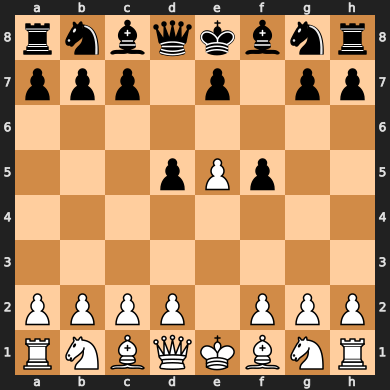

In [220]:
board

In [221]:
print(nodes.shape)
print(edges.shape)

(64, 12)
(2, 1856)


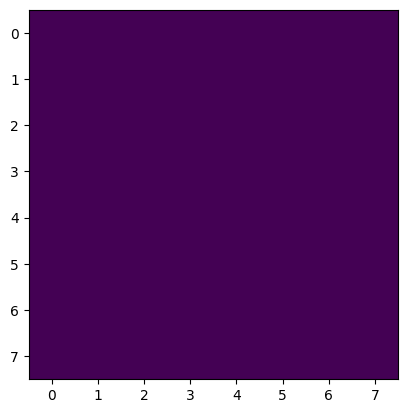

In [222]:
a = np.zeros(64)
a.resize((8, 8))
plt.imshow(a)

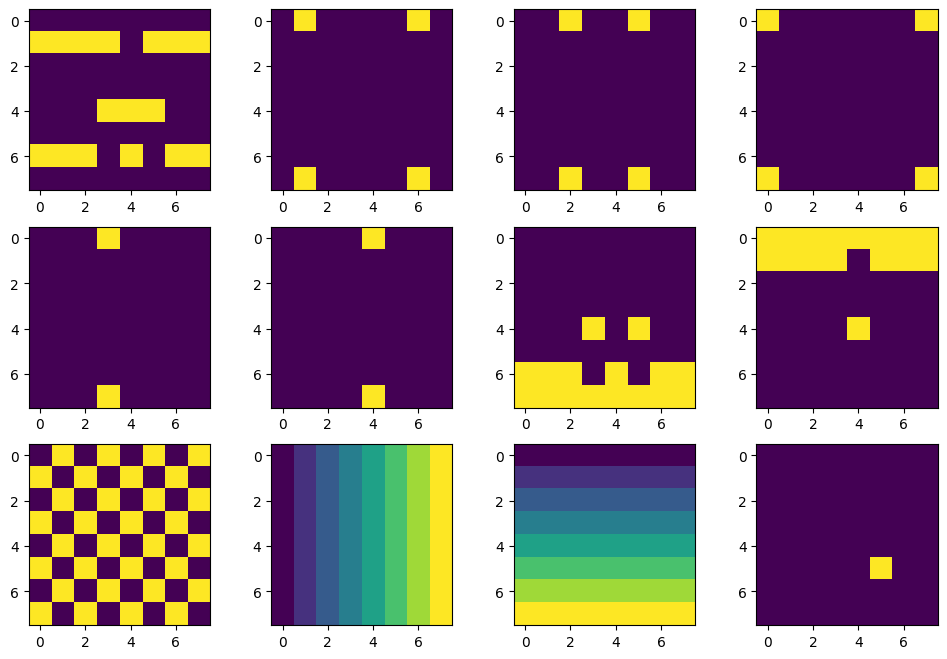

In [223]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(nodes[:, i].reshape(8, 8))

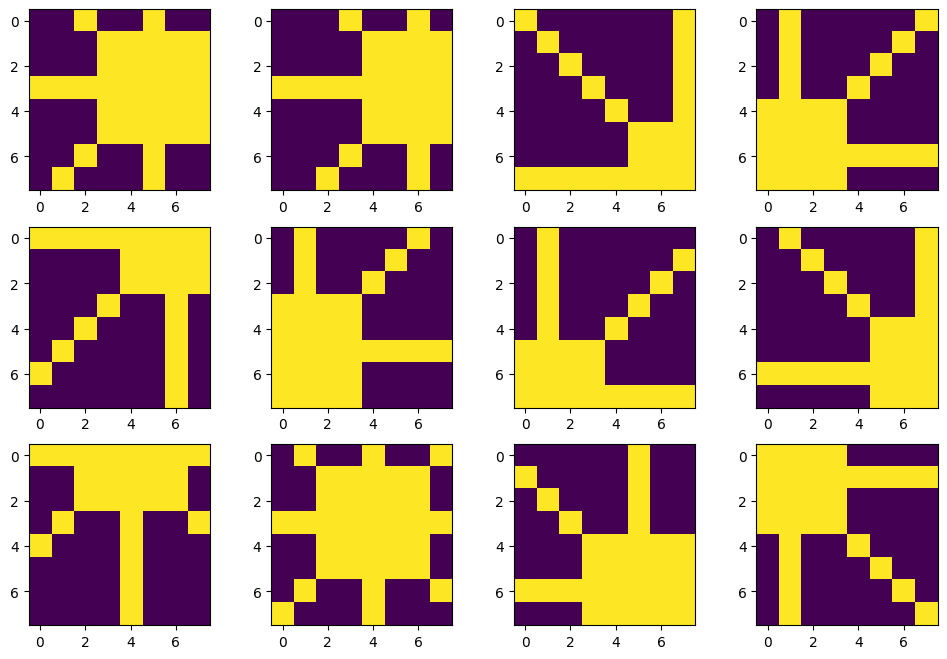

In [224]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

arr1 = np.zeros((12, 64))

arr2 = np.random.randint(64, size=(12))
while len(set(arr2)) != 12:
    arr2 = np.random.randint(64, size=(12))

for i in range(len(arr2)):
    for j in range(edges.shape[1]):
        index = index_of(arr2, edges[0, j])
        if index != -1:
            arr1[index, edges[1, j]] = 1

for i, ax in enumerate(axs.flat):
    ax.imshow(arr1[i].reshape(8, 8))



In [225]:
df = pd.read_csv("kingbase_processed_all.csv")

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684643 entries, 0 to 684642
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Event       684643 non-null  object
 1   Site        684643 non-null  object
 2   Date        684643 non-null  object
 3   White       684643 non-null  object
 4   Black       684643 non-null  object
 5   Result      684643 non-null  object
 6   WhiteElo    684643 non-null  int64 
 7   BlackElo    684643 non-null  int64 
 8   ECO         684643 non-null  object
 9   TotalMoves  684643 non-null  int64 
 10  Moves_UCI   684643 non-null  object
dtypes: int64(3), object(8)
memory usage: 57.5+ MB


In [227]:
def get_board(game_number, move_number):
    all_moves = df["Moves_UCI"]
    move_uci_array = all_moves[game_number].split(" ")
    board = chess.Board()
    for i in range(move_number):
        move = chess.Move.from_uci(move_uci_array[i])
        board.push(move)

    return board, chess.Move.from_uci(move_uci_array[move_number])

In [228]:
game_number = 0
move_number = 0

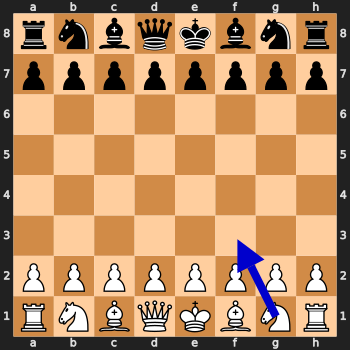

In [229]:
board, move = get_board(game_number, move_number)
svg = chess.svg.board(
    board,
    fill=dict.fromkeys(board.attacks(chess.E4), "#cc0000cc"),
    arrows=[chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")],
    size=350,
) 

move_number += 1

svg

In [230]:
print(len(df))

684643


1-0
False


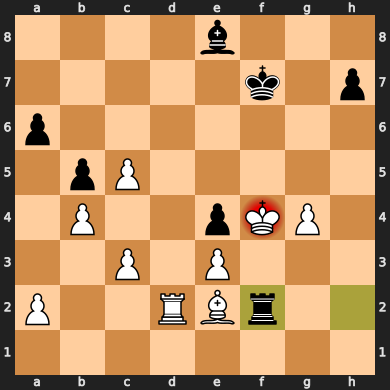

In [231]:
ran = np.random.randint(len(df))

all_moves = df["Moves_UCI"]
move_uci_array = all_moves[ran].split(" ")

board, move = get_board(ran, len(move_uci_array) - 1)

print(df["Result"][ran])
print(board.is_checkmate())
board

C:\Users\Adrian\AppData\Local\Temp\ipykernel_33524\3880835947.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devi

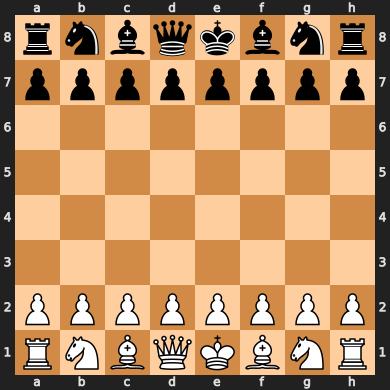

In [ ]:
from our_model2 import ChessGNN
import torch
from our_graph2_encode import encode_node_features, encode_edge_features

device = "cpu"
checkpoint_path = "checkpoint_epoch_41.pth"
NODE_IN_FEATURES = 12
EDGE_IN_FEATURES = 11
GNN_NODE_OUT_FEATURES = 56
GLOBAL_NODE_IN_FEATURES = 9
NUM_POSSIBLE_MOVES = 1792 
model = ChessGNN(
        node_in_features=NODE_IN_FEATURES,
        edge_in_features=EDGE_IN_FEATURES,
        global_node_in_features=GLOBAL_NODE_IN_FEATURES,
        gnn_hidden_features=GNN_NODE_OUT_FEATURES,
        num_possible_moves=NUM_POSSIBLE_MOVES,
    ).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

board = chess.Board()
node = encode_node_features(board)
model.forward()
board